# The astroImage Object #

The astroIm package rebolves around the astroImage class to manipulate fits images, and is tuned to particularly work in with Far-IR/Sub-mm images. Many of the methods provided are wrappers to astropy functions. Here we show some of the more common/basic methods of the astroImage class. To finish the tutorial we show the use-case where you want to match the resolution and projection of one image to another. For more specialised examples see some of our other notebooks or the API.

This tutorial obtains data from the Dustpedia database, however, you can switch it to whatever fits file you want.

## Obtaining Data for this Tutorial ##

First we download example data from the dustpedia database of a SPIRE image of M100.

In [1]:
# import wget module to download data
import urllib.request
import os
from os.path import join as pj

# set folder to store data
folder = "/home/glados/spxmws/Hard-Drive/dustpedia"

# download 250 and 500um data file
if os.path.isfile(pj(folder,"NGC4321_SPIRE_250.fits")) is False:
    urllib.request.urlretrieve("http://www.astro.cf.ac.uk/pub/Matthew.Smith/web/astroIm/NGC4321_SPIRE_250.fits",pj(folder,"NGC4321_SPIRE_250.fits"))
if os.path.isfile(pj(folder,"NGC4321_SPIRE_500.fits")) is False:
    urllib.request.urlretrieve("http://www.astro.cf.ac.uk/pub/Matthew.Smith/web/astroIm/NGC4321_SPIRE_500.fits",pj(folder,"NGC4321_SPIRE_500.fits"))


<h2>Importing the module and loading an image</h2>

In the next box we will open a fits file. The code by defaults to loading the first extension, but other extensions can be loaded with the 'ext=X' parameter. The code searches the header for the instrument, band and units of the image. If this information is not present, it can be added manually (see the commented line below). Instead of a fits file the astroImage class can be initiated with an astropy hdu object (see second commented line).

In [2]:
# import module
#from astroIm import astroImage
import sys
sys.path.append("/home/glados/spxmws/Hard-Drive/scripts/python/astroIm")
from astroIm import astroImage

# load your fits file - adjust path to your fits file
fitsImage = astroImage(pj(folder,"NGC4321_SPIRE_250.fits"))

# load line with extra inputs defined
#fitsImage = astroImage("file.fits", ext=0, instrument='SPIRE', band=250, unit='Jy/pix', "FWHM":10.0)

# load from fits hdu
#fitsImage = astroImage(hduobject, load=False)

As mentioned the code attempts to ascertain the instrument and band (if not given when loading the image).

In [3]:
print(" Telescope: ", fitsImage.telescope)
print("Instrument: ", fitsImage.instrument) 
print("      Band: ", fitsImage.band)

 Telescope:  Herschel
Instrument:  SPIRE
      Band:  250


Instead of providing a 2D image, a cube can be given. For more information how to do this see our 'Loading From a FITS Cube' Notebook

<h2>Aside on Coordinates and Quantities</h2>

The astroImage object tries to make most use of both [astropy](https://www.astropy.org/) SkyCoordinates and [astropy](https://www.astropy.org/) units. This has several advantages, for example when specifing a coordinate the user can specify what coordinate system is used irregardless of the coordinate system of the image, or any units can be used for sizes.

For the remainder of this notebook, we'll specify the centre of M100.

In [4]:
# first let's import astropy units so numbers can be given as quantities, and the SkyCoord class for locations
# import astropy units
import astropy.units as u
# import astropy Sky-Coordinates
from astropy.coordinates import SkyCoord

# set the centre coordinate of M100
centreM100 = SkyCoord(ra=185.72875*u.degree, dec=15.8225*u.degree, frame='icrs')

<h2>Quick Plotting</h2>

Quite often its useful to see a quick image of your data. The astroImage class has a method to obtain a quick image calling the [APLpy](https://aplpy.github.io/) package. The default output is to use a linear stretch:

INFO: Auto-setting vmin to -3.619e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.087e-02 [aplpy.core]


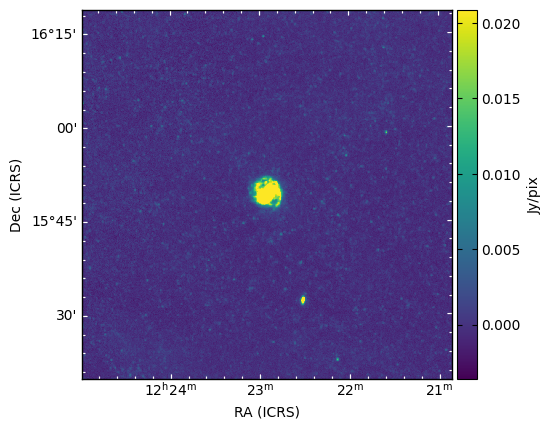

In [5]:
# default plot
fitsImage.plot()

Quite often it is better for large dynamic ranges to use a log scale. The plot method has a algorithm to estimate the best parameters for a logscale:

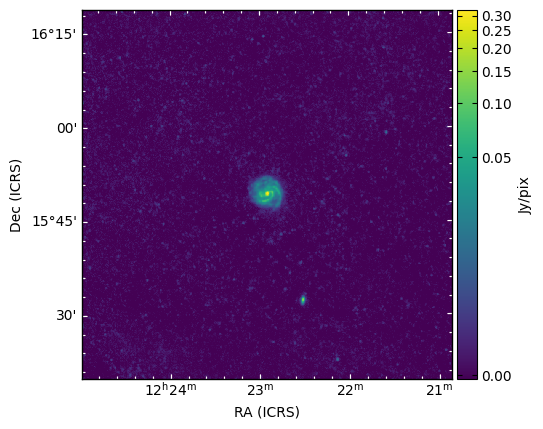

In [6]:
# default quick look plot with log scale
fitsImage.plot(stretch='log')

As a final example we show some of the additional parameters that can be specified to customise the plot. In this example we set the following:
 - *cmap*: change the colour map through the cmap parameter (any colourmaps in matplotlib can be sepicifed). 
 - *hide_colourbar*: set this to True to hide the colourbar from the plot. 
 - *recentre*: The recentre parameter can be used to zoom in a certain region of the image. *recentre* takes a dictionary which specifies the centre by passing a astropy SkyCood through the 'coord' keyword (this is recommended method, for other options see API), and the size by specifing radius through 'rad' keyword (alternatively width and height can be specified for non-square plots).

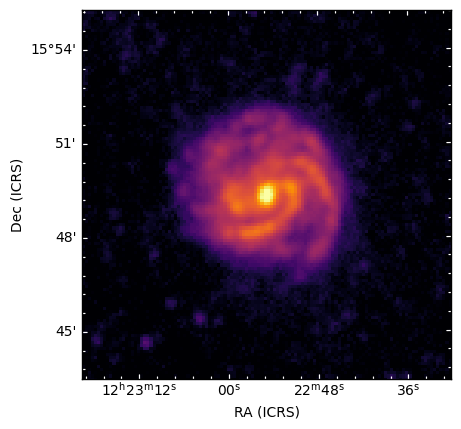

In [7]:
# call quick look plot with log scale, different colourmap,  and centre specified
fitsImage.plot(stretch='log', cmap='inferno', hide_colourbar=True, recentre={"coord":centreM100, "rad":6.0*u.arcmin})

Other useful parameters the user can also specify in the method call are:
  - *save*: use *save* to set the path where to save the plot.
  - *vmin*, *vmax*, *vmid*: the user can specify any of the minimum, maximum or middle (log only) of the colour bar. 
  - *facecolor*: use this parameter to set the background colour outside the images.
  - *nancolour*: use this parameter to set the NaN colour.

<h2>Accessing the image array or header</h2>

Similar to astropy the image array can be found using the image and header attributes. Here, we show this by finding the mean of the image, its unit, and a header keyword.

In [8]:
print("Image Mean: ", fitsImage.image.mean(), fitsImage.unit)
print("Image Reference Pix: (", fitsImage.header['CRPIX1'], ",", fitsImage.header['CRPIX2'], ")")

Image Mean:  8.698689370460493e-05 Jy/pix
Image Reference Pix: ( -498.0 , -4114.0 )


<h2>Obtaining the Pixel Size</h2>

To get the pixel size of the image, just use the 'pixSize' attribute. Sometimes the image header does not contain all the information (or the code could not identify it) when the object was initialised; if you've modified the header the getPixelScale() method will find the pixel size and add the 'pixSize' attribute.

In [9]:
# print the pixel size as attribute
print(fitsImage.pixSize)

# if the header when loading did not have the correct WCS, can run method later to get pixel sizes
#fitsImage.getPixelScale()

6.0 arcsec


<h2>Converting Units</h2>

Possibly one of the most useful features of the astroImage class is that it provides an easy way to switch the image between different units. The user can provide the conversion to use or the beam area to assume if needed (see commented version).

In [10]:
print("Initial Units: ", fitsImage.unit)
print("Peak Pixel: ", fitsImage.image.max(), fitsImage.unit, "\n")


# convert units to that desired
fitsImage.convertUnits("MJy/sr")

# if want to provide the conversion or beam area use the following inputs
#fitsImage.convertUnits("MJy/sr", conversion=1.0, beamArea=1.0)

print()
print("New Units: ", fitsImage.unit)
print("Peak Pixel: ", fitsImage.image.max(), fitsImage.unit, "\n")

Initial Units:  Jy/pix
Peak Pixel:  0.41581757264896013 Jy/pix 

Image converted to:  MJy/sr

New Units:  MJy/sr
Peak Pixel:  491.4174844578513 MJy/sr 



<h2>Simple Image Arithmatic</h2>

This method is a bit redundant, as you can get the image change it how you want and save it back. Alteratively, the imageManipulation method takes operation (either '+','-','*','/','$**$), followed by the value to use. Here we show standard method where we double the image and use the method to restore the image back.

In [11]:
# traditional (and probably more useful method)
fitsImage.image = fitsImage.image * 2.0

# using the method
fitsImage.imageManipulation("/",2.0)


<h2>Finding the Image Noise, Background Subtraction, and Aperture Photometry</h2>

The astro image package provides methods to find the noise in the background of an image, to do a background subtaction around an individual object, and to perform aperture photometry of one or multiple objects. 

**Finding the Background Level of an Image and its Noise, using a Sigma-Clipping Method**

The *background_sigmaClip* method is provided to find the background level and noise of an image. The method tries to identify emission from sources using the astropy [photutils](https://photutils.readthedocs.io/en/stable/) *make_source_mask* task to make a source mask (which is returned by the function). With the mask applied we use the [astropy](https://www.astropy.org/) *sigma_clipped_stats* function to find the sigma-clipped median and standard deviation of the background. The parameters of these two methods can be adjusted (see commented command below).

Both the background level and the noise are stored as the *bkgMedian* and *bkgStd* attributes of the astroImage object. The source mask found is also returned, that way the same source mask can be provided to use on another image via the *maskMatch* parameter.

In [12]:
# first we will switch back to Jy/pix units
fitsImage.convertUnits('mJy/pix')

# run the background analysis to find background median, standard-deviation, and source mask
mask = fitsImage.background_sigmaClip()

# as this runs on the whole image, the median and standard deviation are availabe via the
print("Background level measured as: ", fitsImage.bkgMedian)
print("Bacground noise measured as: ", fitsImage.bkgStd)

Image converted to:  mJy/pix
Background level measured as:  -0.2871480686827673
Bacground noise measured as:  0.5179030411382485


If you want the background level to be automatically subtracted you can set the *apply* parameter to *True*, in this case the *bkgMedian* attribute will equal 0.

In [ ]:
# if you want the background level to be subtracted set apply to True (note then bkgLevel will then be 0):
#mask = fitsImage.background_sigmaClip(apply=True)

Many of the settings for the source-masking and the sigma-clipping can be adjusted, see the API documentation for more details.

You can apply a background subtraction with the *constantBackSub* method, just provide it with the value to subtract. Although this method is redundant with the arithmetic method above.

In [ ]:
# apply a background subtraction
# fitsImage.constantBackSub(fitsImage.bkgMedian)

**Local Object Background Subtraction**

You may wish to choose a particular region of an image to perform a background subtraction and estimate the image noise, for example around a particular source, or if you want to specify particular regions. Two methods are provided do perform a local background subtraction the *circularAnnulusBackSub* and *ellipticalAnnulusBackSub* methods use a circular or ellipical annulus, respectively (both rely on astropy [photutils](https://photutils.readthedocs.io/en/stable/) at their core).

Let's look at the key inputs to these methods:  
<pre>
.circularAnnulusBackSub(<i>centre</i>    => Centre annulus, recommended to provide an astropy SkyCoordinate  
                                     but can be an (X,Y) pixel coordinate instead.
                        <i>inner</i>     => the inner radius of the annulus as an astropy quantity, if just a 
                                     float is provided that is assumed to be in pixels.  
                        <i>outer</i>     => Same as for inner but setting the outer radius.
                        <i>backNoise</i> => Return the standard deviation of the background region. (True/False)
                        <i>apply</i>     => Apply the background subtraction to the image. (True/False)
                       )
</pre>
The *ellipticalAnnulusBackSub* but just has more options due to the shape:
<pre>
.ellipticalAnnulusBackSub(<i>centre</i>      => Centre annulus, recommended to provide an astropy SkyCoordinate  
                                         but can be an (X,Y) pixel coordinate instead.
                          <i>inner</i>       => Either the semi-major axis of the inner ellipse (only if axisRatio
                                         is set) either an astropy quantity or number of pixels,
                                         or a list/tuple/array of the semi-major &amp; semi-minor axis.   
                          <i>outer</i>       => Same as for inner ellipse but size the outer ellipse.
                          <i>PA</i>          => The Position Angle of the ellipses (typically in East of North
                                         but see API for full discussion).
                          <i>axisRatio</i>   => The axis ratio of the ellipses, only required if only the semi-major
                                         values are provided to <i>inner/outer</i>.
                          <i>outerCircle</i> => Set the outer boundary of the annulus to be circular (True/False).
                          <i>backNoise</i>   => Return the standard deviation of the background region. (True/False)
                          <i>apply</i>       => Apply the background subtraction to the image. (True/False)
                       )
</pre>
Additional parameters passed to the photutils function are given in the API. Let's try this method using an annulus around M100..

In [13]:
# perform cicular annulus subtraction and noise analysis
circleBack, circlNoise = fitsImage.circularAnnulusBackSub(centre=centreM100, inner=6.0*u.arcmin, outer=7.0*u.arcmin, backNoise=True)

# perform elliptical annulus subtraction and analysis
ellipseBack, ellipNoise = fitsImage.ellipticalAnnulusBackSub(centre=centreM100, inner=6.0*u.arcmin, outer=7.0*u.arcmin, axisRatio=0.85, PA=30.0*u.deg, outerCircle=True, backNoise=True)

# remember if you want to apply the background subtraction add apply=True to either command

Now let's compare the different values we've measured across all three methods

In [14]:
# Let's now compare the two background and noise estimates
print("\t    Mask/Clip \t Circular    Elliptical ")
print("\t     Method  \t  Annulus      Annulus")
print(f"Background:  {fitsImage.bkgMedian:.2f} \t  {circleBack:.2f}         {ellipseBack:.2f}      (mJy)")
print(f"    Noise:    {fitsImage.bkgStd:.2f} \t   {circlNoise:.2f}          {ellipNoise:.2f}      (mJy)")

	    Mask/Clip 	 Circular    Elliptical 
	     Method  	  Annulus      Annulus
Background:  -0.29 	  -0.03         -0.05      (mJy)
    Noise:    0.52 	   0.76          0.73      (mJy)


<h2>Aperture Photometry</h2>

The astroImage object provides an easy method for performing aperture photometry. Note this procedure is fairly generic and will not do advanced corrections like correcting for extended PSF structure etc... These methods are essentially wrappers to the [photutils](https://photutils.readthedocs.io/en/stable/) aperture photometry functions. 

There are three types of aperture in-built this is circular, elliptical, and rectangular apertures, which can be run with the *circularAperture*, *elipticalAperture*, and the *rectangularAperture* methods. A key thing to know is based if the units of the image is recognised to be a surface-brightness unit (e.g., MJy/sr, or Jy arcsec<sup>-2</sup>). This is easily seen from the output astropy table (see below) where the column changes from *aperture_sum* to *aperture_mean*. 

**Simple Photometry**

Let's try a simple case of using a circular aperture on M100, for this we just need to pass it a centre as the first argument, and radius (again an astropy quantity is recommended, but can also be in pixels). We also provide the name of the object via the *names* parameter: 

In [15]:
# perform circular photometry
circlePhotometry = fitsImage.circularAperture(centreM100, radius=4.2*u.arcmin, names='M100')

# output astropy table
circlePhotometry


id,xcentre,ycentre,sky_centre,number_pixels,aperture_sum
,pix,pix,"deg,deg",,mJy
str4,float64,float64,SkyCoord,float64,float64
M100,300.62492768921277,301.0127673576362,"185.72875,15.8225",5729.051038393129,63249.26594985262


Now we can do a local background subtraction in the same call by using the *localBackSubtract* parameter giving a dictionary with the *inner* and *outer* radius defined. We can also provide an error map via *error* parameter to calculate the 'aperture error' assuming basic Gaussian statistics.

In [16]:
# perform circular photometry with a local background subtraction
circlePhotometry = fitsImage.circularAperture(centreM100, radius=4.2*u.arcmin, localBackSubtract={'inner':5.0*u.arcmin, 'outer':6.0*u.arcmin}, error=fitsImage.image/20.0, names='M100')
circlePhotometry

id,xcentre,ycentre,sky_centre,number_pixels,aperture_sum,aperture_error
,pix,pix,"deg,deg",,mJy,mJy
str4,float64,float64,SkyCoord,float64,float64,float64
M100,300.62492768921277,301.0127673576362,"185.72875,15.8225",5729.051038393129,63509.75518627878,99.84670192416489


Lets now try measuring M100 using an elliptical aperture, a rectangular aperture, and compare the results. The elliptical aperture can be defined with *major* (semi-major axis), either *minor* or *axisRatio*, and *PA* (if using *localBackSubtract* can specify *outerCircle* if want the outer part of the background subtraction to be circular). For rectangular photometry, need to specify the *length*, *width* or "ratio", and *PA* of the rectangle (note any background annulus uses the same lenght ratios).

In [17]:
# perform elliptical aperture photometry
ellipsePhotometry = fitsImage.ellipticalAperture(centreM100, major=4.2*u.arcmin, axisRatio=0.85, PA=30.0*u.deg, localBackSubtract={'inner':5.0*u.arcmin, 'outer':6.0*u.arcmin, "outerCircle":True})

# perform rectangular photometry
rectanglePhotometry = fitsImage.rectangularAperture(centreM100, length=8.4*u.arcmin, width=8.40*u.arcmin, PA=0.0*u.deg, localBackSubtract={'inner':9.0*u.arcmin, 'outer':10.0*u.arcmin})

circlePhotometry['aperture_sum'][0]

print(f"   Circle Flux: {circlePhotometry['aperture_sum'][0]/1000.0:.1f} Jy  ({circlePhotometry['number_pixels'][0]:.0f} Pixels)")
print(f"  Ellipse Flux: {ellipsePhotometry['aperture_sum'][0]/1000.0:.1f} Jy  ({ellipsePhotometry['number_pixels'][0]:.0f} Pixels)")
print(f"Rectangle Flux: {rectanglePhotometry['aperture_sum'][0]/1000.0:.1f} Jy  ({rectanglePhotometry['number_pixels'][0]:.0f} Pixels)")


   Circle Flux: 63.5 Jy  (5729 Pixels)
  Ellipse Flux: 63.2 Jy  (4870 Pixels)
Rectangle Flux: 62.9 Jy  (7294 Pixels)


Let's just show a quick example where we do everything in pixel coordinates.

In [18]:
# circular photometry with pixels
pixPhotometry = fitsImage.circularAperture((301.6,302.0), radius=42.0, localBackSubtract={'inner':50.0, 'outer':60.0})
print(f"Pixel Flux: {pixPhotometry['aperture_sum'][0]/1000.0:.1f} Jy  ({pixPhotometry['number_pixels'][0]:.0f} Pixels)")

Pixel Flux: 63.4 Jy  (5542 Pixels)


**Multi-Object Photometry**

Quite often you will want to perform aperture photometry on more than one object, and there are variety of ways you can do this. Let's start by simultaneously measuring M100 and NGC4312 another extended local galaxy.

The first method is instead of providing the centre as the first argument instead a dictionary is provided where each item is an object to perform photometry on, and each item is a dictionary given details of the settings to use. This is easiest to show in an example:

In [19]:
# First let's set the centre of NGC4312 with an astropy SkyCoord
centreNGC4312 = SkyCoord(185.63, 15.538, unit="deg", frame="icrs")

# create a dictionary for all objects, each object is a dictionary of the properties to use the object's aperture
galInfo = {'M100':{'centre':centreM100, 'major':4.2*u.arcmin, 'minor':3.57*u.arcmin, "PA":30.0*u.deg, "localBackSubtract":{'inner':5.0*u.arcmin, 'outer':6.0*u.arcmin, "outerCircle":True}},\
           'NGC4312':{'centre':centreNGC4312, 'major':1.12*u.arcmin, 'axisRatio':0.733, "PA":-8.0*u.deg, "localBackSubtract":{'inner':2.0*u.arcmin, 'outer':3.0*u.arcmin, "outerCircle":True}}}

# perform the elliptical aperture photometry
ellipsePhotometry = fitsImage.ellipticalAperture(galInfo)
ellipsePhotometry

id,xcentre,ycentre,sky_centre,number_pixels,aperture_sum
,pix,pix,"deg,deg",,mJy
str7,float64,float64,SkyCoord,float64,float64
M100,300.62492768921277,301.0127673576362,"185.72875,15.8225",4869.693382634159,63156.35042532697
NGC4312,358.79071249937226,127.9484369738675,"185.63,15.538",297.90231527550327,3863.7703873104265


Alternatively, instead of providing a dictionary of all the objects (e.g., galInfo above), each of the inputs as in the single object photometry examples above can be instead be parsed a list of the parameters to vary.

In [20]:
# perform elliptical aperture photometry with each parameter a list of the values for each object.
ellipsePhotometry = fitsImage.ellipticalAperture([centreM100,centreNGC4312], major=[4.2*u.arcmin,1.12*u.arcmin], minor=[3.57*u.arcmin, 0.82*u.arcmin], PA=[30*u.deg, -8.0*u.deg], localBackSubtract=[{'inner':5.0*u.arcmin, 'outer':6.0*u.arcmin, "outerCircle":True}, {'inner':2.0*u.arcmin, 'outer':3.0*u.arcmin, "outerCircle":True}])
ellipsePhotometry

id,xcentre,ycentre,sky_centre,number_pixels,aperture_sum
,pix,pix,"deg,deg",,mJy
int64,float64,float64,SkyCoord,float64,float64
1,300.62492768921277,301.0127673576362,"185.72875,15.8225",4869.693382634159,63156.35042532697
2,358.79071249937226,127.9484369738675,"185.63,15.538",297.5539594205718,3863.526647752747


In some circumstances you may want the apertures or some properties to all be the same size (like when measuring many background point sources). In this case any of the parameters can be kept fixed by giving a parameter a single value.

In [21]:
centres = [SkyCoord(185.7962, 15.7438, unit="deg", frame="icrs"),\
           SkyCoord(185.6075, 15.8213, unit="deg", frame="icrs"),\
           SkyCoord(185.5368, 15.8798, unit="deg", frame="icrs")]

circlePhotometry = fitsImage.circularAperture(centres, radius=25.0*u.arcsec, localBackSubtract={'inner':30.0*u.arcsec, 'outer':35.0*u.arcsec}, backMedian=True)
circlePhotometry

id,xcentre,ycentre,sky_centre,number_pixels,aperture_sum
,pix,pix,"deg,deg",,mJy
int64,float64,float64,SkyCoord,float64,float64
1,261.51047946757205,252.75900484353042,"185.7962,15.7438",56.34229724849712,84.86525625700989
2,371.2373339240496,300.76652986114004,"185.6075,15.8213",56.38975988296721,29.67393691509062
3,412.26842421475055,336.76401854742926,"185.5368,15.8798",56.42293457996087,55.97412747525641


<h2>Curve's of Growth and Radial Profiles</h2>

Instead of using a single aperture on an object, sometimes you may want to see how the flux of the source changes with the size of your aperture, or see what the radial profile is of your object. The aperture photometry commands in the previous section can be easily adjusted to do this by setting the *multiRadius* parameter to True.

*(Note for rectangular case setting multi-radius to True, that the length parameter is now the semi-length)*

In [22]:
# import numpy
import numpy as np

radialProfile = fitsImage.ellipticalAperture(centreM100, multiRadius=True, major=np.arange(0,306.0,6.0)*u.arcsec, axisRatio=0.85, PA=30.0*u.deg, localBackSubtract={'inner':5.0*u.arcmin, 'outer':6.0*u.arcmin, "outerCircle":True}, names='M100')
radialProfile

Semi-Major,M100_number_pixels,M100_aperture_sum,M100_surface_brightness
arcsec,,mJy,mJy / arcsec2
float64,float64,float64,float64
0.0,0.0,0.0,11.546161649078428
6.0,2.7605971556882993,1098.432183565224,10.11443169667982
12.0,11.042388622753196,3653.87058662665,7.038465460942497
18.0,24.845374401194693,6364.165882440539,4.108954563503969
24.0,44.169554491012775,8537.12525834311,2.381548136584748
30.0,69.01492889220748,10281.333099984115,1.6707773543073523
36.0,99.38149760477876,11922.16356221521,1.3982516794998534
42.0,135.2692606287266,13657.104892493693,1.3160997018197291


You may also want to do radial profiles for more than one object. Here is an example of applying this method to two extended objects in the image, each with its own local background subtraction.

In [23]:
galInfo = {"M100":{"centre":centreM100, "axisRatio":0.85, "PA":30.0*u.deg, "localBackSubtract":{'inner':5.0*u.arcmin, 'outer':6.0*u.arcmin}, "outerCircle":True},\
           "NGC4312":{'centre':centreNGC4312, 'axisRatio':0.733, "PA":-8.0*u.deg, "localBackSubtract":{'inner':2.0*u.arcmin, 'outer':3.0*u.arcmin, "outerCircle":True}}}

radialProfile = fitsImage.ellipticalAperture(galInfo, multiRadius=True, major=np.arange(0,306.0,6.0)*u.arcsec)
radialProfile

Semi-Major,M100_number_pixels,M100_aperture_sum,NGC4312_number_pixels,NGC4312_aperture_sum,M100_surface_brightness,NGC4312_surface_brightness
arcsec,,mJy,,mJy,mJy / arcsec2,mJy / arcsec2
float64,float64,float64,float64,float64,float64,float64
0.0,0.0,0.0,0.0,0.0,11.544817798251167,4.025233936923345
6.0,2.7605971556882993,1098.2986296574534,2.37485901845905,324.38574804846957,10.113087845852561,3.4904781063370636
12.0,11.042388622753196,3653.3363709955684,9.4994360738362,1106.4559151567905,7.037121610115237,2.5374070160908273
18.0,24.845374401194693,6362.963897270603,21.373731166131446,1952.5368041925663,4.107610712676708,1.5084780488683034
24.0,44.169554491012775,8534.988395818784,37.9977442953448,2618.523752842624,2.3802042857574874,0.7905789650684748
30.0,69.01492889220748,10277.994252289851,59.37147546147626,3055.285393143966,1.6694335034800925,0.4118563714500249
36.0,99.38149760477876,11917.355621535471,85.49492466452578,3344.932485644836,1.3969078286725944,0.23216848996805053
42.0,135.2692606287266,13650.560751012938,116.36809190449344,3541.428218361798,1.3147558509924682,0.13275286393712155


In [24]:
radialProfile = fitsImage.ellipticalAperture([centreM100,centreNGC4312], multiRadius=True, major=np.arange(0,306.0,6.0)*u.arcsec, axisRatio=[0.85,0.733], PA=[30.0*u.deg, -8.0*u.deg], localBackSubtract=[{'inner':5.0*u.arcmin, 'outer':6.0*u.arcmin},{'inner':2.0*u.arcmin, 'outer':3.0*u.arcmin, "outerCircle":True}], names=['M100','NGC4312'])
radialProfile

Semi-Major,M100_number_pixels,M100_aperture_sum,NGC4312_number_pixels,NGC4312_aperture_sum,M100_surface_brightness,NGC4312_surface_brightness
arcsec,,mJy,,mJy,mJy / arcsec2,mJy / arcsec2
float64,float64,float64,float64,float64,float64,float64
0.0,0.0,0.0,0.0,0.0,11.544817798251167,4.025233936923345
6.0,2.7605971556882993,1098.2986296574534,2.37485901845905,324.38574804846957,10.113087845852561,3.4904781063370636
12.0,11.042388622753196,3653.3363709955684,9.4994360738362,1106.4559151567905,7.037121610115237,2.5374070160908273
18.0,24.845374401194693,6362.963897270603,21.373731166131446,1952.5368041925663,4.107610712676708,1.5084780488683034
24.0,44.169554491012775,8534.988395818784,37.9977442953448,2618.523752842624,2.3802042857574874,0.7905789650684748
30.0,69.01492889220748,10277.994252289851,59.37147546147626,3055.285393143966,1.6694335034800925,0.4118563714500249
36.0,99.38149760477876,11917.355621535471,85.49492466452578,3344.932485644836,1.3969078286725944,0.23216848996805053
42.0,135.2692606287266,13650.560751012938,116.36809190449344,3541.428218361798,1.3147558509924682,0.13275286393712155


Text(0, 0.5, 'Surface-Brightness Profile (mJy / arcsec2)')

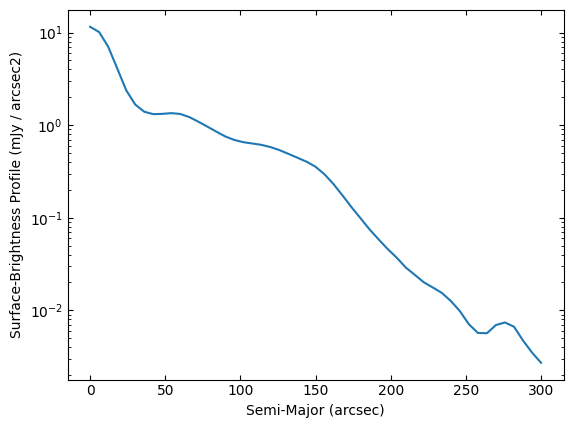

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()
f1 = plt.axes()
f1.plot(radialProfile['Semi-Major'], radialProfile['M100_surface_brightness'])
f1.set_yscale('log')
f1.set_xlabel("Semi-Major (" + str(radialProfile['Semi-Major'].unit) + ")")
f1.set_ylabel("Surface-Brightness Profile (" + str(radialProfile['M100_surface_brightness'].unit) + ")")

<h1>Example Matching Resolution and Projection of One Image to Another</h1>

To finish this tutorial we're going to look at a typical use case where you want to convole and project one image to match another.

<h2>Convolution</h2>

First we need to convolve the image to match the spatial resolution, but we need to define how to go from one to another. The convolve method provides a handy way to perform the convolution creating a new astroImage. This can be done in two ways:
 - Provide a kernel with a 2D numpy array. This is best to provide an exact match (note the pixel size must match). Eventually this package will access a database of kernels, or generate its own.
 - Assume everything is Gaussian. By default you can provide the FWHM of the Gaussian (in angular units) to convolve the image (or the standard deviation if set FWHM=False)
The default is to preserve flux but by setting the 'peakNorm' to True you can conserve peak flux (note though the code cannot update beam areas/FWHM yet. Finally, the 'boundary' and 'fill_value' parameters can be given to the astropy convolution routine. 

In our example we'll assume the simple example that the 250&#181;m and 500&#181;m images have Gaussian PSFs of 18 and 36 arcseconds. Examples of the convolve method shown below:

In [26]:
# import numpy and astropy.units
import numpy as np
import astropy.units as u

# Calculate the FWHM of the Gaussian we want to convolve the image by
convFWHM = np.sqrt((36.0*u.arcsecond)**2.0 - (18.0*u.arcsecond)**2.0)

# convolve the image
smo250 = fitsImage.convolve(convFWHM)

# alteratively if wanted to provide standard deviation
#smo250 = fitsImage.convolve(convSTD, FWHM=False)

# to provide a kernel imaage just load/create the array
#smo250 = fitsImage.convolve(kernelImage)

# to conserve the peak rather than total flux
#smo250 = fitsImage.convolve(convFWHM, peakNorm=True)


<h2>Reproject</h2>

The next stage is to reproject the data so the image projection is the same (i.e., the pixels all line up). The astroImage object has the reproject method which works as a wrapper for the reporject package. The user must supply a header to reproject the image to, but can switch to the interpolation method by serring 'exact=False', or can specify to conserve flux (rather than surface-brightness) by setting 'conserveFlux=True'. Note that if the units of the image are 'Jy/pix' or 'mJy/pix' then the method will automatically conserve flux.

In [27]:
# open the 500um image with astroImage
image500 = astroImage(pj(folder,"NGC4321_SPIRE_500.fits"), dustpediaHeaderCorrect=True)

# reproject the smoothed 250 image
reproSmo250 = smo250.reproject(image500.header)

# example with other keywords added
#reproSmo250 = smo250.reproject(image500.header, exact=False, conserveFlux=True)

Let's see how our smoothed and reprojected 250&#181;m map compares to the 500&#181;m map using our quick plot method:

Original 250um Image


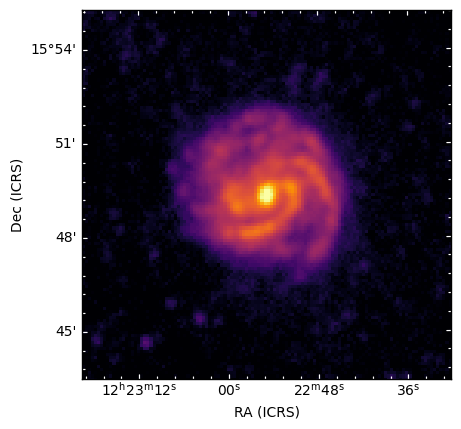

In [28]:
print("Original 250um Image")
fitsImage.plot(stretch='log', cmap='inferno', hide_colourbar=True, recentre={"RA":185.72875*u.degree, "DEC":15.8225*u.degree, "rad":6.0*u.arcmin})

Smooth and Reprojected 250um Image


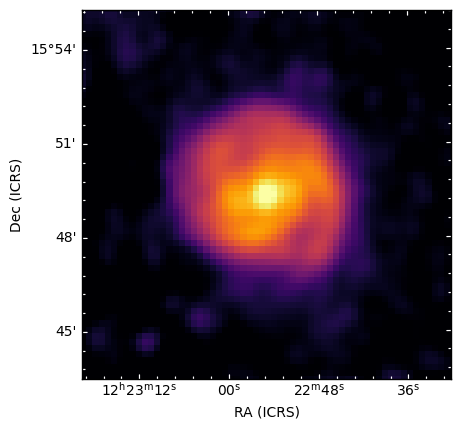

In [29]:
print("Smooth and Reprojected 250um Image")
reproSmo250.plot(stretch='log', cmap='inferno', hide_colourbar=True, recentre={"RA":185.72875*u.degree, "DEC":15.8225*u.degree, "rad":6.0*u.arcmin})

500um Image


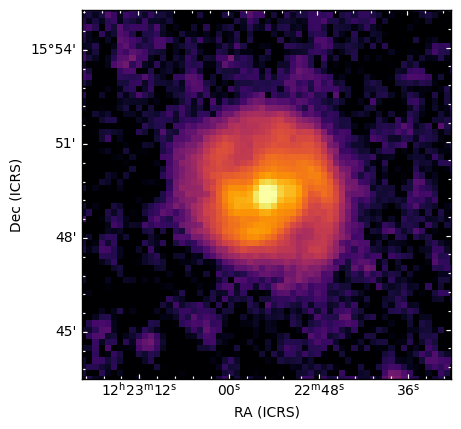

In [30]:
print("500um Image")
image500.plot(stretch='log', cmap='inferno', hide_colourbar=True, recentre={"RA":185.72875*u.degree, "DEC":15.8225*u.degree, "rad":6.0*u.arcmin})

<h2>Cutouts</h2>

Cutout description here.

In [31]:
# create a cutout on M100
cutout250 = reproSmo250.cutout(SkyCoord(ra=185.72875*u.degree, dec=15.8225*u.degree, frame='icrs'), 12.0*u.arcmin)

# plot the cutout image
reproSmo250.plot(stretch='log', cmap='inferno', hide_colourbar=True)

AttributeError: 'bool' object has no attribute 'deepcopy'

<h2>Saving the astro image</h2>

The astroImage object can be saved to a fits file, using the saveToFits method. This method takes the path to the location where you want to save the file, and you can allow the method to overwrite an exisiting file (just the same as astropy).

In [ ]:
reproSmo250.saveToFits(pj(folder,"reproSmo250.fits"), overwrite=True)

<h2>Other Advanced Methods</h2>

There are also some more advance methods described in other notebooks, these are:
 - Colour-correct -> apply colour-corrections to the map
 - Central Wavelength Adjust -> Adjust the central wavelength assuming a model.
 - FFT combine -> Our method for 'feathering' FIR/sub-mm images to combine low and high-resolution images.